# Skin_Disease_Detection_Project

# About the Dataset:
This dataset is a collection of images representing various skin diseases, categorized into 20  classes. It provides an invaluable resource for image classification tasks, particularly in the fields of dermatology and medical diagnostics.

### Skin Diseases:
Acne, Actinic Carcinoma, Atopic Dermatitis, Bullous Disease, Cellulitis, Eczema, Drug Eruptions, Herpes HPV, Light Diseases, Lupus, Melanoma, Poison IVY, Psoriasis, Benign Tumors, Systemic Disease, Ringworm, Urticarial Hives, Vascular Tumors, Vasculitis, Viral Infections.

## Why this project
Skin diseases affect millions globally, ranging from benign conditions like acne to life-threatening ones like melanoma. Early and accurate diagnosis is critical but access to dermatologists is limited and expensive, especially in underserved regions like Kenya. Our goal is to be able to upload an image of your skin and our project will be able to classify what type of condition you have.

## Objectives:
* Is it possible to upload images to our deployed model to identify the skin disease?
* Improve diagnostic efficiency by automating skin condition  diagnosis and cutting down on delays.
* Expand access by enabling mobile diagnosis tools for rural areas.
* Reduce costs to minimize unnecessary trips to doctors and biopsies.
* Enhance patient outcomes by  supporting early detection of serious conditions like skin cancer.


# 1. EDA and Data Understanding

### Import modules

In [1]:
# Import Libraries
import os
import cv2
import random
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import json
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

In [2]:
# Set seeds for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [3]:
# Set plot style
sns.set(style='whitegrid')

## Explore dataset

Let's define the dataset path and explore the folder structure.

In [4]:
# Define dataset paths
DATASET_DIR = Path("datasets/Dataset")
TRAIN_DIR = DATASET_DIR / "train"
TEST_DIR = DATASET_DIR / "test"

# Explore dataset structure
train_classes = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
test_classes = sorted([d.name for d in TEST_DIR.iterdir() if d.is_dir()])

print(f"Train classes: {len(train_classes)}")
print(f"Test classes: {len(test_classes)}")
print("Sample classes:", train_classes[:5])

extra_test_class = set(test_classes) - set(train_classes)
print("Class in test but not in train:", extra_test_class)

Train classes: 19
Test classes: 20
Sample classes: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos']
Class in test but not in train: {'Bullous Disease Photos'}


We've confirmed that the dataset has 19 training classes and 20 test classes and it is organized into subfolders, one per skin disease category. Our observation is that the test set has 1 more class than the training set.

We found that the test set contains one additional class Bullous Disease Photos which is not present in the training set. This will lead to a cold start problem, as the model will not have learned to recognize this class. Unless training data for this class is added, we should exclude it from performance evaluation or explicitly note it as a limitation of the dataset.

In [5]:
# Classes to exclude 
EXCLUDED_CLASSES = {"Bullous Disease Photos"}

## Count Images per Class (Train vs Test)

Let's count the number of .jpg images in each class folder for both train/ and test/ splits as this will help reveal the overall dataset size and the per-class distribution which we will use for class imbalance detection.

In [6]:
def count_images(folder, excluded_classes=None):
    if excluded_classes is None:
        excluded_classes = set()
    return {
        cls.name: len(list(cls.glob("*.jpg")))
        for cls in folder.iterdir()
        if cls.is_dir() and cls.name not in excluded_classes
    }

train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR, excluded_classes=EXCLUDED_CLASSES)

# Combine into DataFrame
df_dist = pd.DataFrame({
    "Class": list(train_counts.keys()),
    "Train Count": list(train_counts.values()),
    "Test Count": [test_counts.get(cls, 0) for cls in train_counts.keys()]
})
df_dist["Total"] = df_dist["Train Count"] + df_dist["Test Count"]
df_dist = df_dist.sort_values("Total", ascending=False)

print(df_dist.head())

                                                Class  Train Count  \
0                             Acne and Rosacea Photos          840   
1   Actinic Keratosis Basal Cell Carcinoma and oth...          322   
7        Light Diseases and Disorders of Pigmentation          299   
18         Warts Molluscum and other Viral Infections          248   
14  Tinea Ringworm Candidiasis and other Fungal In...          122   

    Test Count  Total  
0          231   1071  
1          120    442  
7           30    329  
18          51    299  
14          42    164  


We've observed that class "Acne and Rosacea Photos" has by far the most samples (840 in train, 231 in test). Other classes like “Tinea Ringworm” have significantly fewer images. This confirms a strong class imbalance.

Models trained on imbalanced datasets tend to become biased toward overrepresented classes which will lead to poor generalization. In medical diagnosis tasks, this can have critical consequences.

## Plot Distribution (Train vs Test)

Let's visualise the number of images per class in both the training and test sets for easy visualisations.

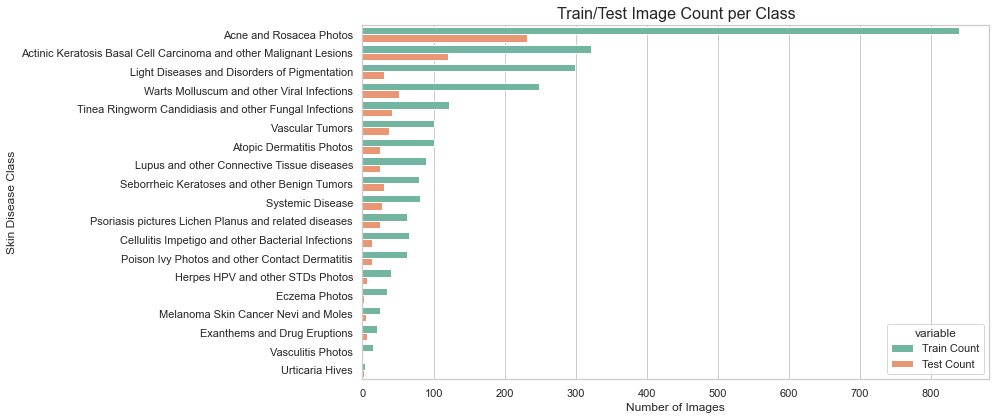

In [7]:
plt.figure(figsize=(14, 6))
df_melted = df_dist.melt(id_vars="Class", value_vars=["Train Count", "Test Count"])

sns.barplot(data=df_melted, x="value", y="Class", hue="variable", palette="Set2")
plt.title("Train/Test Image Count per Class", fontsize=16)
plt.xlabel("Number of Images")
plt.ylabel("Skin Disease Class")
plt.tight_layout()
plt.show()


The dataset follows a long-tail pattern, where a few classes dominate the total image count, and the majority of classes have very few examples which should be addressed.

It contains 20 skin disease classes in both train and test folders. It is severely imbalanced as the class “Acne and Rosacea Photos” alone has over 800 training images, which far exceeds all others.

On the opposite extreme, several classes such as “Urticaria Hives”, “Vasculitis Photos”, and “Exanthems and Drug Eruptions” have fewer than 50 images in total.

Test sets are consistently smaller but some classes e.g., “Urticaria Hives” appear to have no test examples at all or a very small number which may hinder generalization performance tracking.

## Image Dimension Analysis

Let's examine the width and height of all images in both train and test folders to ensures that preprocessing will not lead to loss of crucial visual features.

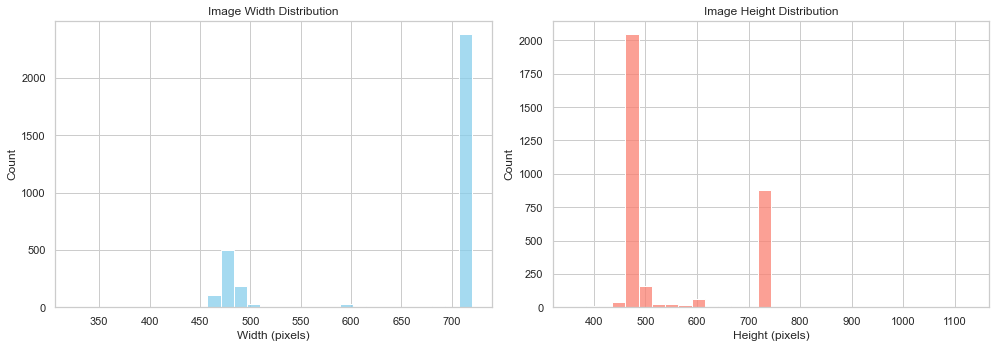

In [8]:
def collect_image_sizes(folder):
    sizes = []
    for class_dir in folder.iterdir():
        if class_dir.is_dir():
            for img_path in class_dir.glob("*.jpg"):
                try:
                    with Image.open(img_path) as img:
                        sizes.append(img.size)
                except:
                    continue
    return sizes

train_sizes = collect_image_sizes(TRAIN_DIR)
test_sizes = collect_image_sizes(TEST_DIR)
all_sizes = train_sizes + test_sizes

widths = [w for w, h in all_sizes]
heights = [h for w, h in all_sizes]

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=30, color='skyblue')
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=30, color='salmon')
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.tight_layout()
plt.show()

Most images are around 480–500 pixels wide, with a major peak at around 720 pixels. Most images fall between 480 and 750 pixels, with some outliers up to 1100 pixels tall. The majority of the dataset is reasonably consistent in size, but there are a few scattered outliers.

### importing of the models we will be using

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator #image classification model
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

What Does ImageDataGenerator Do?
ImageDataGenerator:

Loads images from directories in real time

Applies preprocessing and augmentation

Feeds data into your model in batches, preventing memory overload

In [2]:
#importing of the data
train_dir = 'datasets/Dataset/train' #contains labled data for training the model
test_dir = 'datasets/Dataset/test' # contains untrained data


In [3]:
#creating a pipeline for imagegenerator for easy data cleaning and classification of each image for ease of code
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),#reshaping them for each picture to be 64 x 64 pixels
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64), #reshaping them for each picture to be 64 x 64 pixels
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2092 images belonging to 19 classes.
Found 517 images belonging to 19 classes.


#### Parameter
* rescale=1./255	Normalizes pixel values to [0, 1] 
* range	Crucial for stabilizing neural network training
* rotation_range=20	Randomly rotates images (up to 20 degrees)	Helps model generalize better across rotated inputs
* zoom_range=0.2	Random zoom-in/out up to 20%	Makes model robust to varied image scales
* horizontal_flip=True	Randomly flips images horizontally	Useful for symmetric patterns in skin lesions
* validation_split=0.2	Splits 20% of training data for validation	Vital for performance tracking during training

In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,  # assuming test is unlabeled
    shuffle=False
)


Found 897 images belonging to 20 classes.


### Previewing images
* IMAGE WARNING!!!

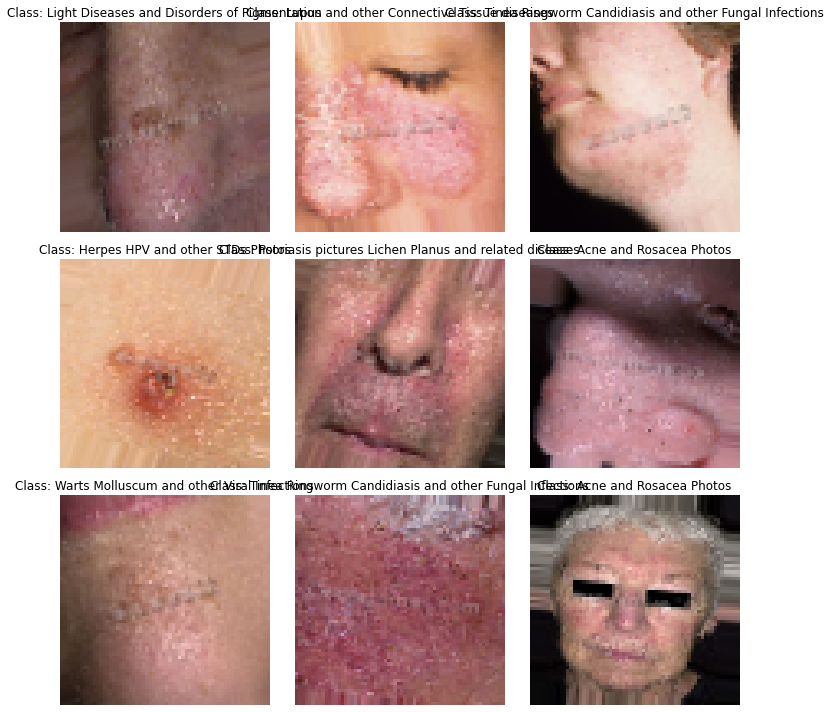

In [5]:
#plotting the images in the dataset
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {list(train_generator.class_indices.keys())[np.argmax(labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
# they are blurry are we reduced the image size to 64x64 size

# building a base model

In [6]:
model = Sequential()
#1 layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

#2 layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Learns more abstract patterns such as roughness, discoloration, or shape irregularities of skin lesions.
#3 layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#4 layer
model.add(Flatten())
#Converts the pooled feature maps into a one-dimensional vector that the Dense layers can process.
model.add(Dropout(0.5))
#Randomly disables 50% of neurons during training to prevent overfitting and improve generalization on unseen skin images.
#5 layer
model.add(Dense(128, activation='relu'))
#Learns complex combinations of features for decision-making
#output layer
model.add(Dense(20, activation='softmax'))
#The softmax activation outputs probabilities across 20 skin disease classes—making this perfect for multi-class classification.


Conv2D: for feature detection (like skin patterns) /Detects edges, shapes, and textures using 32 filters of size 3x3.

input_shape: Matches your image size and channels (RGB).

MaxPooling: Cuts image size in half while preserving key features./for reducing spatial dimensions

Flatten: to convert features into a flat vector

Dense: for classification layers

Dropout: for regularization to avoid overfitting

#### Training the data

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


#### HAVING ISSUES WITH THE FIT FUNCTION FIX IF POSSIBLE!!!

# model.fit(
#     train_generator,         
#     validation_data=val_generator,  
#     epochs=10                 
# )


# improving on the base model